In [1]:
#Import Packages
import os
import pandas as pd
import numpy as np

#Change Working Directory
os.chdir(r'C:\Users\malva\Thesis')

#Read data file
data = pd.read_csv('Files\Samples\ValdAran_Sample.csv')
data.head()

,lat,long,elevation,slope,aspect,curv_plan,curv_prof,facc,twi,soil,lulc,rain_ant,rain_event,pof_event,pof_dry,pof_sat,response
0,4738872.5,311597.5,790.80,13.145604,327.05750,0.025769,-0.010359,1.397940,4.673251,2.0,3.0,0.5,49.0,0.0000,0.0000,1.0000,1.0
1,4738862.5,311617.5,794.77,18.441340,307.93506,-0.117006,-0.044545,2.352183,6.514342,2.0,3.0,0.5,49.0,0.0000,0.0000,1.0000,1.0
2,4738697.5,319872.5,1709.36,43.968290,173.81042,0.000644,0.018706,2.889302,6.688886,8.0,1.0,0.5,70.0,0.8803,0.3543,0.1197,1.0
3,4737832.5,318912.5,1285.22,47.644943,194.89754,0.076285,0.069331,0.000000,-11.605381,8.0,1.0,0.5,69.0,0.6894,0.5387,0.1381,1.0
4,4737377.5,317017.5,1734.32,39.489166,182.85223,-0.000287,-0.003942,3.122216,7.382731,8.0,1.0,0.5,67.0,0.6695,0.0711,0.3305,1.0


In [2]:
print('Soil: ' + str(sorted(data['soil'].unique())))
print('LULC: ' + str(sorted(data['lulc'].unique())))

Soil: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
LULC: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0]


In [3]:
#Encoding Categorical with Pandas
X = pd.get_dummies(data, columns = ['soil', 'lulc'])
X = X.drop(columns=['lat', 'long', 'elevation', 'pof_event', 'pof_dry', 'pof_sat', 'response'])

In [4]:
#Complete missing columns
X['lulc_7.0'] = 0
X['lulc_10.0'] = 0
X.sort_index(axis=1, inplace=True)
X.columns

Index(['aspect', 'curv_plan', 'curv_prof', 'facc', 'lulc_1.0', 'lulc_10.0',
       'lulc_2.0', 'lulc_3.0', 'lulc_4.0', 'lulc_5.0', 'lulc_6.0', 'lulc_7.0',
       'lulc_8.0', 'lulc_9.0', 'rain_ant', 'rain_event', 'slope', 'soil_1.0',
       'soil_10.0', 'soil_11.0', 'soil_2.0', 'soil_3.0', 'soil_4.0',
       'soil_5.0', 'soil_6.0', 'soil_7.0', 'soil_8.0', 'soil_9.0', 'twi'],
      dtype='object')

In [5]:
#Create inputs and outputs for the data-driven model
y = data['response'].values

In [6]:
# Split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
%%time
#SVM with Cross-validation (5-fold) and parameter optimization
#No Rainfall

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV 

svc = SVC(probability = True)
param_grid = [{'kernel': ['rbf'], 'gamma': [0.1,0.5,1,2,5,10], 'C': [0.1, 1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
              {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [0.1, 1, 10, 100, 1000]}]
clf_norain = RandomizedSearchCV(svc, n_iter=50, param_distributions = param_grid, scoring = 'roc_auc', verbose = True, n_jobs = -1, cv = 5)
best_svc_norain = clf_norain.fit(X_train.drop(columns=['rain_ant', 'rain_event']),y_train)

results_norain = pd.DataFrame(clf_norain.cv_results_)
print('Best Score: ' + str(best_svc_norain.best_score_))
print('Best Parameters: ' + str(best_svc_norain.best_params_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Score: 0.7843237674469286
Best Parameters: {'kernel': 'linear', 'C': 1}
Wall time: 22min 5s


In [8]:
#SVM with Cross-validation (5-fold) and parameter optimization
#Rainfall

from sklearn.model_selection import RandomizedSearchCV 

svc = SVC(probability = True)
param_grid = [{'kernel': ['rbf'], 'gamma': [0.1,0.5,1,2,5,10],
                                  'C': [0.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_rain = RandomizedSearchCV(svc, n_iter=50, param_distributions = param_grid, scoring = 'roc_auc', verbose = True, n_jobs = -1, cv = 5)
best_svc_rain = clf_rain.fit(X_train,y_train)

results_rain = pd.DataFrame(clf_rain.cv_results_)
print('Best Score: ' + str(best_svc_rain.best_score_))
print('Best Parameters: ' + str(best_svc_rain.best_params_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Score: 0.7912886705167955
Best Parameters: {'kernel': 'poly', 'degree': 2, 'C': 1000}


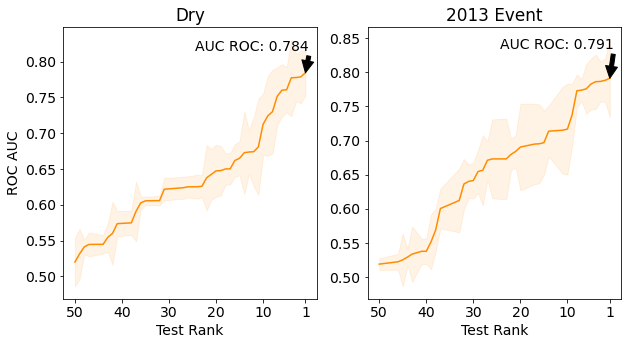

In [9]:
#Training Plots
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
xtickslabels = [50, 40, 30, 20, 10, 1]

#No Rain
results_norain.sort_values(by=['rank_test_score'], inplace=True)
test_scores = results_norain['mean_test_score']
test_ranks = results_norain['rank_test_score']
test_error = results_norain['std_test_score']

ax[0].plot(test_ranks, test_scores, color='darkorange')
ax[0].fill_between(test_ranks, test_scores-test_error, test_scores+test_error, color='darkorange', alpha=.1)
ax[0].annotate(text = "AUC ROC: " + str(round(results_norain['mean_test_score'].max(),3)),
             xy = (1, results_norain['mean_test_score'].max()),
             xytext=(0.2, 0.83),arrowprops=dict(facecolor='black'),
            horizontalalignment='right', verticalalignment='top')
ax[0].invert_xaxis()
ax[0].set_title('Dry')
ax[0].set_xlabel('Test Rank')
ax[0].set_xticks(xtickslabels)
ax[0].set_ylabel('ROC AUC')

#Rain
results_rain.sort_values(by=['rank_test_score'], inplace=True)
test_scores = results_rain['mean_test_score']
test_ranks = results_rain['rank_test_score']
test_error = results_rain['std_test_score']

ax[1].plot(test_ranks, test_scores, color='darkorange')
ax[1].fill_between(test_ranks, test_scores-test_error, test_scores+test_error, color='darkorange', alpha=.1)
ax[1].annotate(text = "AUC ROC: " + str(round(results_rain['mean_test_score'].max(),3)),
             xy = (1, results_rain['mean_test_score'].max()),
             xytext=(0.2, 0.85),arrowprops=dict(facecolor='black'),
            horizontalalignment='right', verticalalignment='top')
ax[1].invert_xaxis()
ax[1].set_xticks(xtickslabels)
ax[1].set_title('2013 Event')
ax[1].set_xlabel('Test Rank')

plt.savefig(r'C:\Users\malva\Desktop\Test\trainingsvc.png', dpi=300)
plt.show()

In [10]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

#Support vector classifier

#No Rainfall
y_pred_prob_norain = best_svc_norain.predict_proba(X_test.drop(columns=['rain_ant', 'rain_event']))[:, 1]

fpr_norain, tpr_norain, thresholds_norain = metrics.roc_curve(y_test, y_pred_prob_norain)
auc_norain = metrics.roc_auc_score(y_test, y_pred_prob_norain)

#Rainfall
y_pred_prob_rain = best_svc_rain.predict_proba(X_test)[:, 1]

fpr_rain, tpr_rain, thresholds_rain = metrics.roc_curve(y_test, y_pred_prob_rain)
auc_rain = metrics.roc_auc_score(y_test, y_pred_prob_rain)

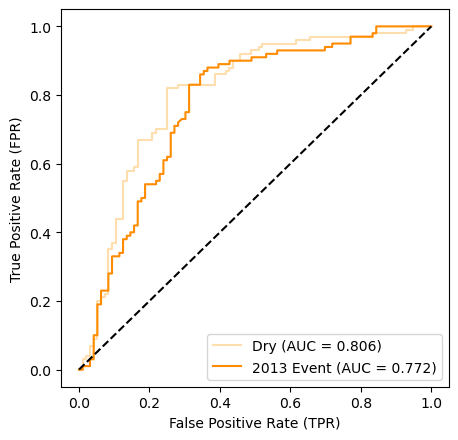

In [11]:
#Plot the ROC curve and calculate AUC
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr_norain, tpr_norain, marker='', color='navajowhite', label='Dry (AUC = %0.3f)' % auc_norain)
plt.plot(fpr_rain, tpr_rain, marker='', color='darkorange', label='2013 Event (AUC = %0.3f)' % auc_rain)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (TPR)')
plt.ylabel('True Positive Rate (FPR)')
plt.legend()
plt.savefig(r'C:\Users\malva\Desktop\Test\rocSVC.png', dpi=300)
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef

#No Rain
y_pred_norain = best_svc_norain.predict(X_test.drop(columns=['rain_ant', 'rain_event']))
matrix_norain = confusion_matrix(y_test, y_pred_norain)
acc_norain = accuracy_score(y_test, y_pred_norain)
FP = matrix_norain[0,1]
TN = matrix_norain[0,0]
fpr_norain = FP/(FP+TN)
fnr_norain = 1 - recall_score(y_test, y_pred_norain)
mcc_norain = matthews_corrcoef(y_test, y_pred_norain)
stats_norain = '\n\nAccuracy = {:0.3f}\nFPR = {:0.3f}\nFNR = {:0.3f}\nMCC = {:0.3f}'.format(acc_norain, fpr_norain, fnr_norain, mcc_norain)


#No Rain
y_pred_rain = best_svc_rain.predict(X_test)
matrix_rain = confusion_matrix(y_test, y_pred_rain)
acc_rain = accuracy_score(y_test, y_pred_rain)
FP = matrix_rain[0,1]
TN = matrix_rain[0,0]
fpr_rain = FP/(FP+TN)
fnr_rain = 1 - recall_score(y_test, y_pred_rain)
mcc_rain = matthews_corrcoef(y_test, y_pred_rain)
stats_rain = '\n\nAccuracy = {:0.3f}\nFPR = {:0.3f}\nFNR = {:0.3f}\nMCC = {:0.3f}'.format(acc_rain, fpr_rain, fnr_rain, mcc_rain)

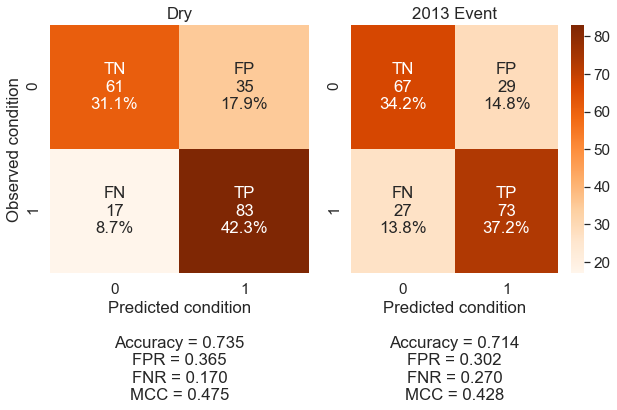

In [13]:
import seaborn as sns

sns.set(font_scale=1.4)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))

low_lim = np.min(np.concatenate((matrix_norain, matrix_rain)))
upp_lim = np.max(np.concatenate((matrix_norain, matrix_rain)))

#Heatmap No Rain
group_names = ['TN', 'FP','FN', 'TP']
group_counts = ['{0:0.0f}'.format(value) for value in matrix_norain.flatten()]
group_percentages = ['{0:.1%}'.format(value) for value in matrix_norain.flatten()/np.sum(matrix_norain)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix_norain, vmin=low_lim, vmax=upp_lim, annot=labels, fmt='', cbar=False, cmap='Oranges', ax=ax[0])

#Heatmap Rain
group_counts = ['{0:0.0f}'.format(value) for value in matrix_rain.flatten()]
group_percentages = ['{0:.1%}'.format(value) for value in matrix_rain.flatten()/np.sum(matrix_rain)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix_rain, vmin=low_lim, vmax=upp_lim, annot=labels, fmt='', cbar=True, cmap='Oranges', ax=ax[1])

ax[0].set_title('Dry')
ax[1].set_title('2013 Event')
ax[0].set_ylabel('Observed condition')
ax[0].set_xlabel('Predicted condition' + stats_norain)
ax[1].set_xlabel('Predicted condition' + stats_rain)
plt.tight_layout()
plt.savefig(r'C:\Users\malva\Desktop\Test\confusionSVC.png', dpi=300)
plt.show()

In [14]:
#Save models as Pickles
import pickle

pkl_filename = 'Files\Models\svc_norain.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_svc_norain, file)
    
pkl_filename = 'Files\Models\svc_rain.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_svc_rain, file)